<a href="https://colab.research.google.com/github/mohanrajmit/Rainstreaks_Removal/blob/main/LP_detection_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mohanrajmit/Rainstreaks_Removal.git

Cloning into 'Rainstreaks_Removal'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 283 (delta 55), reused 260 (delta 44), pack-reused 0
Receiving objects: 100% (283/283), 25.97 MiB | 27.11 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
cd /content/Rainstreaks_Removal/alpr-unconstrained-master/darknet

/content/Rainstreaks_Removal/alpr-unconstrained-master/darknet


In [3]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -fopenmp -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -fopenmp -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -fopenmp -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -fopenmp -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -fopenmp -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -fopenmp -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-er

In [4]:
cd ..

/content/Rainstreaks_Removal/alpr-unconstrained-master


In [5]:
!ls

annotation-tool.py  get-networks.sh		README.md  train-detector.py
create-model.py     LICENSE			run.sh	   vehicle-detection.py
darknet		    license-plate-detection.py	samples
gen-outputs.py	    license-plate-ocr.py	src


In [6]:
import sys, os
import keras
import cv2
import traceback

from src.keras_utils 			import load_model
from glob 						import glob
from os.path 					import splitext, basename
from src.utils 					import im2single
from src.keras_utils 			import load_model, detect_lp
from src.label 					import Shape, writeShapes

In [7]:
def adjust_pts(pts,lroi):
	return pts*lroi.wh().reshape((2,1)) + lroi.tl().reshape((2,1))

In [8]:


lp_threshold = .5

wpod_net_path = "/content/Rainstreaks_Removal/data/lp-detector/wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

imgs_paths = "/content/Rainstreaks_Removal/20.png"

#print 'Searching for license plates using WPOD-NET'


print('\t Processing %s' % imgs_paths)

bname = splitext(basename(imgs_paths))[0]
Ivehicle = cv2.imread(imgs_paths)

ratio = float(max(Ivehicle.shape[:2]))/min(Ivehicle.shape[:2])
side  = int(ratio*288.)
bound_dim = min(side + (side%(2**4)),608)
print("\t\tBound dim: %d, ratio: %f" % (bound_dim,ratio))

Llp,LlpImgs,_ = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold)

if len(LlpImgs):
  Ilp = LlpImgs[0]
  Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
  Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)

  s = Shape(Llp[0].pts)

  cv2.imwrite('output_lpdetect.png',Ilp*255.)
  #writeShapes('%s/%s_lp.txt' % (output_dir,bname),[s])




	 Processing /content/Rainstreaks_Removal/20.png
		Bound dim: 446, ratio: 1.499118


In [9]:
w =Ivehicle.shape[0]
h =Ivehicle.shape[1]


In [10]:
for shape in [s]:
  ptsarray = shape.pts.flatten()
  frame = cv2.rectangle(Ivehicle,(int(ptsarray[0]*h), int(ptsarray[5]*w)),(int(ptsarray[1]*h),int(ptsarray[6]*w)),(0,255,0),3)

In [11]:
import matplotlib.pyplot as plt 

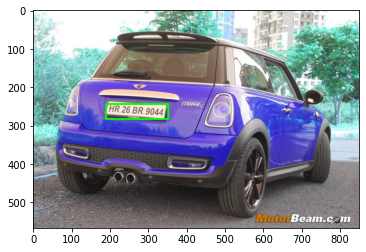

In [12]:
 plt.imshow(Ivehicle)    

In [13]:
output_img=cv2.imread("/content/Rainstreaks_Removal/alpr-unconstrained-master/output_lpdetect.png")

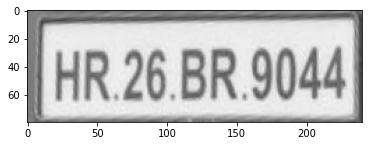

In [14]:
plt.imshow(output_img)  

In [15]:

import sys
import cv2
import numpy as np
import traceback

import darknet.python.darknet as dn

from os.path 				import splitext, basename
from glob					import glob
from darknet.python.darknet import detect
from src.label				import dknet_label_conversion
from src.utils 				import nms

In [16]:
ocr_threshold = .4

ocr_weights = b'/content/Rainstreaks_Removal/data/ocr/ocr-net.weights'
ocr_netcfg  = b'/content/Rainstreaks_Removal/data/ocr/ocr-net.cfg'
ocr_dataset = b'/content/Rainstreaks_Removal/data/ocr/ocr-net.data'

ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
#ocr_meta = dn.load_meta(ocr_dataset)

In [17]:
ocr_meta = dn.load_meta(ocr_dataset)

In [18]:
img_path = b"/content/Rainstreaks_Removal/alpr-unconstrained-master/output_lpdetect.png"




bname = basename(splitext(img_path)[0])

R,(width,height) = detect(ocr_net, ocr_meta, img_path ,thresh=ocr_threshold, nms=None)

if len(R):

  L = dknet_label_conversion(R,width,height)
  L = nms(L,.45)

  L.sort(key=lambda x: x.tl()[0])
  lp_str = ''.join([chr(l.cl()) for l in L]) 

  print('\t\tLP: %s' % lp_str)

else:

  print('No characters found')

		LP: HR26BR9044


In [24]:
cv2.putText(Ivehicle, lp_str, (int(ptsarray[0]*h), int(ptsarray[5]*w)-5), cv2.FONT_HERSHEY_SIMPLEX,1.5, (255,0,0), 2)

array([[[240, 255, 251],
        [238, 252, 248],
        [238, 249, 246],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[246, 255, 252],
        [244, 253, 250],
        [243, 252, 249],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[252, 254, 254],
        [252, 254, 254],
        [252, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[138, 130, 130],
        [141, 133, 133],
        [146, 138, 138],
        ...,
        [152, 139, 141],
        [113, 105, 106],
        [123, 115, 116]],

       [[140, 130, 130],
        [127, 117, 117],
        [117, 109, 109],
        ...,
        [137, 124, 126],
        [130, 122, 123],
        [136, 128, 129]],

       [[112, 102, 102],
        [121, 111, 111],
        [133, 125, 125],
        ...,
        [127, 113, 115],
        [110, 102, 103],
        [107,  99, 100]]

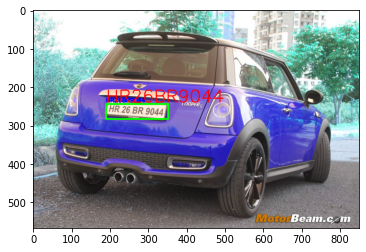

In [25]:
 plt.imshow(Ivehicle)    